# Density and Distribution-Based Clustering

In [1]:
import pandas as pd
import numpy as np
from numpy import array, linspace

from matplotlib import pyplot as plt
from matplotlib.pyplot import plot
import seaborn as sns; sns.set()
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from sklearn.mixture import GaussianMixture as GMM

## Data: FCC Measuring Broadband America 

Let's first load the throughput and latency data from the [FCC Measuring Broadband America program](https://www.fcc.gov/oet/mba/raw-data-releases) from March 2020. We'll restrict ourselves to look at a single day to speed up some of the clustering examples. This [data dictionary](https://data.fcc.gov/download/measuring-broadband-america/2018/Technical-Appendix-fixed-2018.pdf) is also a useful reference for this dataset.

In [2]:
df = pd.read_csv('../data/curr_httpgetmt.csv.gz', compression='gzip', error_bad_lines=False)
df_backup = df.copy()

df = df.loc[:,['unit_id','dtime','target','address','bytes_sec']]
df = df[(df['dtime'] < '2020-03-02') & (df['target']=='samknows1.nyc2.level3.net')]
df.head(10)

,unit_id,dtime,target,address,bytes_sec
0,386,2020-03-01 00:35:07,samknows1.nyc2.level3.net,4.71.185.62,18693531
3,386,2020-03-01 01:35:10,samknows1.nyc2.level3.net,4.71.185.62,20522792
6,386,2020-03-01 02:39:52,samknows1.nyc2.level3.net,4.71.185.62,21314905
8,386,2020-03-01 03:34:56,samknows1.nyc2.level3.net,4.71.185.62,21955952
10,386,2020-03-01 04:34:51,samknows1.nyc2.level3.net,4.71.185.62,23254307
13,386,2020-03-01 08:31:08,samknows1.nyc2.level3.net,4.71.185.62,19111163
16,386,2020-03-01 14:33:08,samknows1.nyc2.level3.net,4.71.185.62,22520834
23,390,2020-03-01 00:51:50,samknows1.nyc2.level3.net,4.71.185.62,11708887
26,390,2020-03-01 01:55:39,samknows1.nyc2.level3.net,4.71.185.62,11750100
28,390,2020-03-01 02:51:51,samknows1.nyc2.level3.net,4.71.185.62,11704172


### Throughput Measurements: Data Preparation

We can find the **mean** throughput measurement for each unit in the dataset and plot the result.

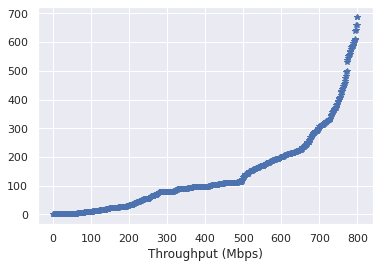

In [3]:
# Take the mean throughput measurement for each unit.
mean_df = df.groupby(['unit_id']).mean()
mean_df = mean_df.sort_values(by=['bytes_sec'])

# Drop garbage data and unnecessary colums.
mean_df = mean_df.replace(0, np.nan).dropna().reset_index()
#mean_df.drop(columns=['dtime','address'],inplace=True)

# Create a rank so that we plot in order of increasing throughput.
mean_df.reset_index()
mean_df['rank'] = mean_df.index

# Create a column for "speed" which is throughput in megabits per second (a common metric).
mean_df['speed'] = (mean_df['bytes_sec']*8)/(1024*1024)


plt.plot(mean_df.index,mean_df['speed'],'*')
plt.xlabel('Throughput (Mbps)')
plt.show()

### Latency Measurements: Data Preparation

The FCC Measuring Broadband America program also measures a quantity called latency, which is how long it takes to reach a particular location on the Internet from each measurement point.  Let's have a quick look at that data.

In [4]:
dfp = pd.read_csv('../data/curr_ping.csv.gz', compression='gzip', error_bad_lines=False)
dfp_backup = dfp.copy

dfp = dfp.loc[:,['unit_id','dtime','target','rtt_avg']]
dfp = dfp[(dfp['dtime'] < '2020-03-02') & (dfp['target']=='samknows1.nyc2.level3.net')]

mean_dfp = dfp.groupby(['unit_id']).mean()
mean_dfp = mean_dfp.sort_values(by=['rtt_avg'])
mean_dfp = mean_dfp.replace(0, np.nan).dropna().reset_index()

mean_dfp.head(10)

,unit_id,rtt_avg
0,8449,4414.000000
1,4803413,4735.750000
2,942052,4768.277778
3,948742,5044.125000
4,32508,5271.500000
5,942046,5518.470588
6,23665993,5556.458333
7,1002270,5569.875000
8,25170377,5646.750000
9,942170,5782.456522


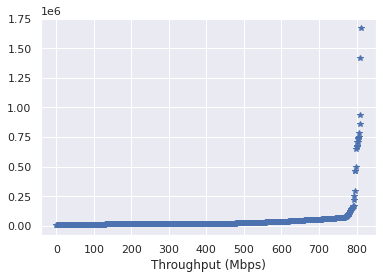

In [5]:
plt.plot(mean_dfp.index,mean_dfp['rtt_avg'],'*')
plt.xlabel('Throughput (Mbps)')
plt.show()

## Density Estimation

### Throughput: 1-D Kernel Density Estimation

Kernel density estimation can help us determine where the data is located in this distribution.  You can play with different kernels and bandwidth values for the kernel to see how that results in different probbility estimates.

Already we can see that these estimates can help us better understand where the mass is in the probability distribution.

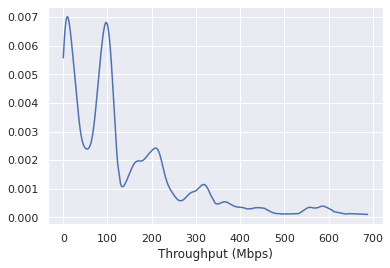

In [6]:
speed = mean_df['speed'].values.reshape(-1,1)
kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(speed)
e = np.exp(kde.score_samples(speed))
plt.xlabel('Throughput (Mbps)')
plot(speed,e,'-')
plt.show()

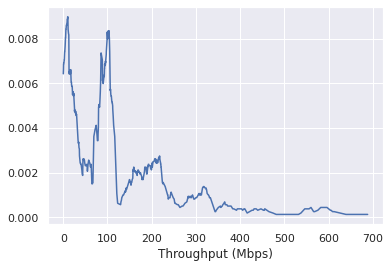

In [7]:
speed = mean_df['speed'].values.reshape(-1,1)
kde = KernelDensity(kernel='tophat', bandwidth=10).fit(speed)
e = np.exp(kde.score_samples(speed))
plt.xlabel('Throughput (Mbps)')
plot(speed,e,'-')
plt.show()

### Latency: 1-D Kernel Density Estimation

We can perform the same kernel density estimation procedure for the latency values to see how these are distributed. Most are in expected ranges for a nearby server, but one can see that occassionally there are some extremely large latency values. A check on the data shows that in some cases, round-trip latency even exceeds several seconds. We leave this in the dataset as it is a valid measurement, but understanding that these outliers exist are important.

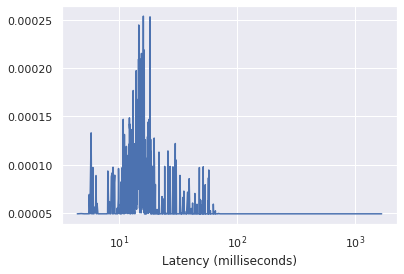

In [8]:
latency = mean_dfp['rtt_avg'].values.reshape(-1,1)
kde_l = KernelDensity(kernel='gaussian', bandwidth=10).fit(latency)
e_l = np.exp(kde_l.score_samples(latency))
plt.xscale('log')
plt.xlabel('Latency (milliseconds)')
plt.plot(latency/1000,e_l,'-')
plt.show()

## Clustering

The first step in preparation for clustering is to put the points into a multi-dimensional space and visualize them. Once we have created these tuples, we can then try to form clusters on them using various techniques.  

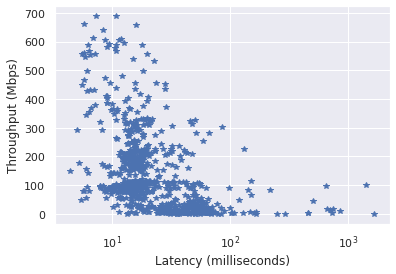

In [9]:
all_df = mean_df.merge(mean_dfp,on='unit_id')
l = (all_df['rtt_avg']/1000).values.reshape(-1,1)
s = all_df['speed'].values.reshape(-1,1)
plt.xscale('log')
plt.xlabel('Latency (milliseconds)')
plt.ylabel('Throughput (Mbps)')

plt.plot(l,s,'*')
plt.show()

### DBScan

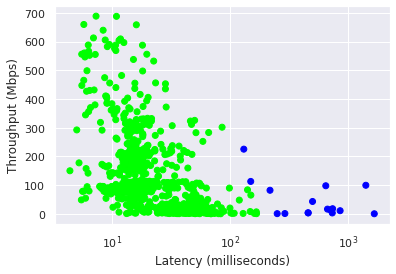

In [10]:
cluster = DBSCAN(min_samples=10, eps=0.5)
X = all_df.loc[:,['rtt_avg','speed']]

scaler = StandardScaler()
X_std = scaler.fit_transform(X)
model = cluster.fit(X_std)

labels = model.labels_

plt.xscale('log')
plt.xlabel('Latency (milliseconds)')
plt.ylabel('Throughput (Mbps)')
plt.scatter(l,s, c=labels, cmap='brg')
plt.show()

### Gaussian Mixture Model (GMM)

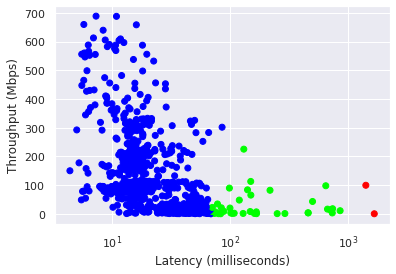

In [11]:
gmm = GMM(n_components=3).fit(X)
labels = gmm.predict(X)

plt.xscale('log')
plt.xlabel('Latency (milliseconds)')
plt.ylabel('Throughput (Mbps)')
plt.scatter(l,s, c=labels, cmap='brg')
plt.show()

---

## Lecture Examples

Below are some examples used in the first part of the video lecture, on sample data.

### Kernel Density Estimation

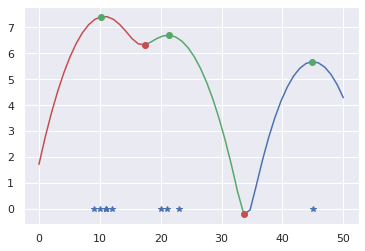

In [12]:
from scipy.signal import argrelextrema

a = array([10,11,9,23,21,11,45,20,11,12]).reshape(-1, 1)

kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(a)
s = linspace(0,50)
e = kde.score_samples(s.reshape(-1,1)) + 10
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]

plot(a,np.zeros(len(a)),'*')
plot(s[:mi[0]+1], e[:mi[0]+1], 'r',
     s[mi[0]:mi[1]+1], e[mi[0]:mi[1]+1], 'g',
     s[mi[1]:], e[mi[1]:], 'b',
     s[ma], e[ma], 'go',
     s[mi], e[mi], 'ro')

plt.show()

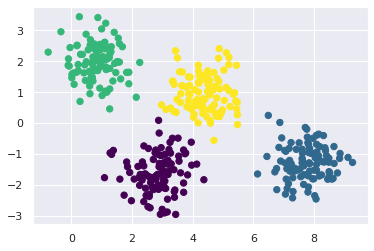

In [13]:
# Generate some data
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

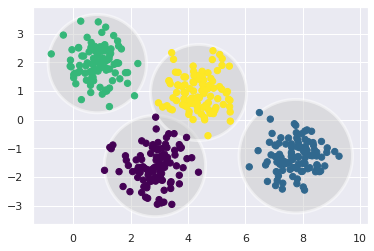

In [14]:
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))


kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

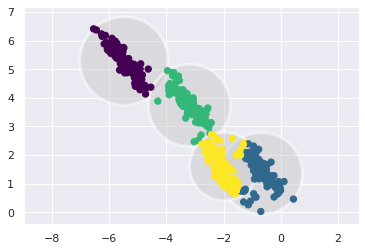

In [15]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

plot_kmeans(kmeans, X_stretched)

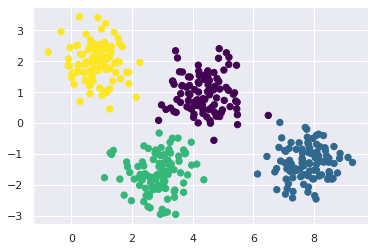

In [16]:
gmm = GMM(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');